# ECJ Beta Test: Data Summary and Exploration
A look at the data we gathered as part of the ECJ Beta test.

In [1]:
import sys
sys.path.append("../")
from src.data import make_airthings_dataset
from src.visualization import visualize

import pandas as pd
import numpy as np

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

<a id="toc"></a>

# Table of Contents
1. [Experiment Details](#details)
2. [Full Beta Test](#beta)
3. [AirThings and Beacon Integration](#airthings_beacon_integration)
4. Debugging Source Code
    1. [`make_airthings_dataset`](#make_airthings_dataset_debug)

---

<a id="details"></a>

# Experiment Details
Important Dates:
* Deployment Start: 02/10/2022
* RPi Beacon Deployment Start (3rd Floor): 03/01/2022
* Deployment End (5th Floor): 03/10/2022
* Deployment End (3rd Floor): 03/29/2022

We have two separate sub-tests we want to consider:
1. [Full Beta Test](#beta): Data should be available from all _ten_ devices from 02/10 to 03/10
2. [Third Floor AirThings and Beacon Integration Test](#airthings_beacon_integration): Data should be available from _five_ devices from 03/01 to 03/29

---

<a id="beta"></a>

[Back to ToC](#toc)
# Beta Test

---

<a id="airthings_beacon_integration"></a>

[Back to ToC](#toc)
# AirThings and Beacon Integration Test
I developed a script that pulls data from each of the RPi Beacons based on their Tailscale IP address. See the [source code](https://github.com/intelligent-environments-lab/bleed-orange-measure-iaq/blob/master/src/data/make_airthings_dataset.py).

The data imported below is the output from running that script.

In [2]:
at_data = pd.read_csv("../data/processed/airthings-data.csv",
                      index_col="timestamp",parse_dates=True,infer_datetime_format=True)

In [3]:
devices = at_data["device"].unique()
print("Number of Devices:", len(devices))
for device in devices:
    print(f"\t{device}")

Number of Devices: 5
	2930041730
	2930041961
	2930042307
	2930042428
	2930042521


## Data Availability

In [4]:
summary = visualize.AirThingsSummary()

2930041730


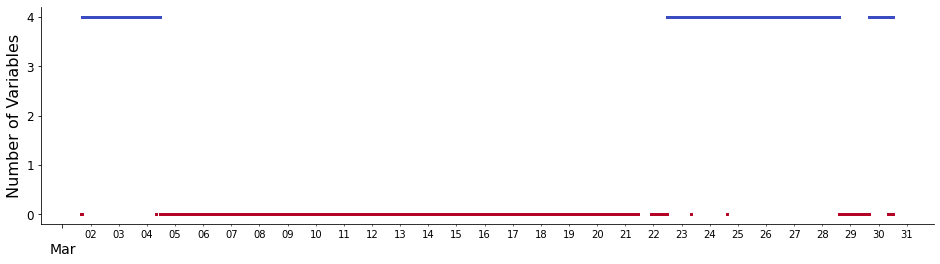

2930041961


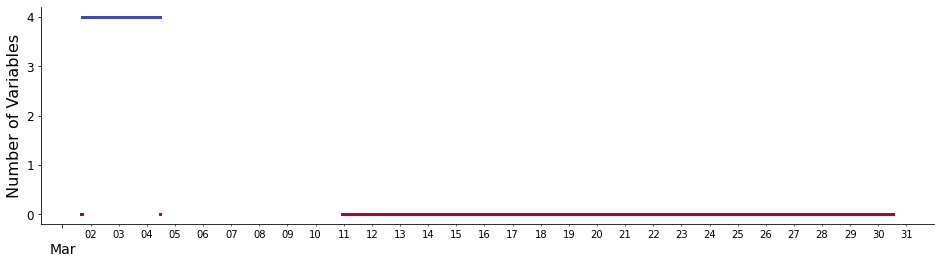

2930042307


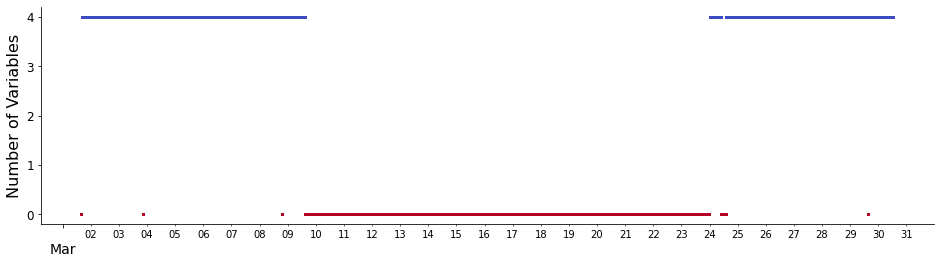

2930042428


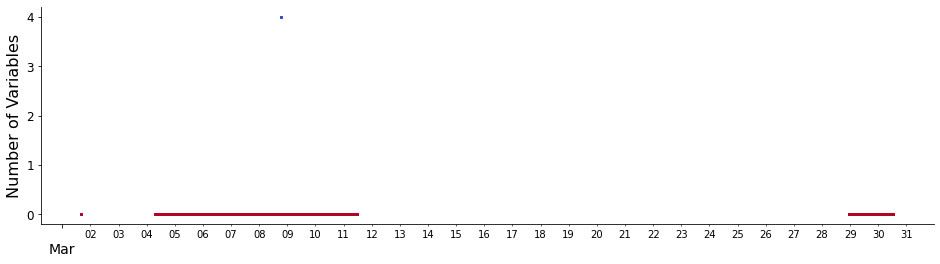

2930042521


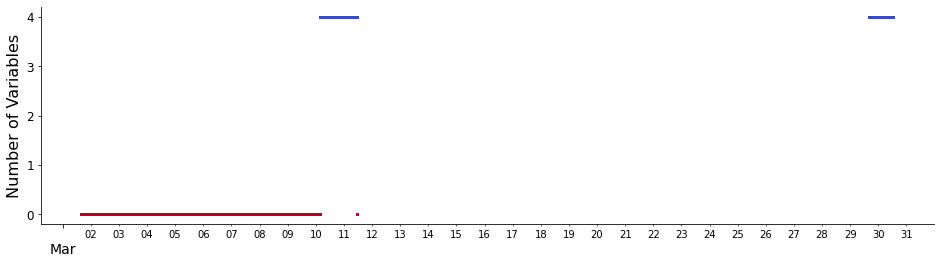

In [5]:
for device in at_data["device"].unique():
    data_device = at_data[at_data["device"] == device]
    print(device)
    summary.plot_data_availability(data_device)

<div class="alert-block alert alert-danger">
    
Overall, the beta test was a _failure_.
    
<div>

Some insights:
* 3/5 devices were initially successful in connecting to their AirThings sensor and worked between 4 and 9 days before data logging was lost. 
* 2/5 devices were initially _unsucessful_, but were able to log data after the initial period (only _one_ data point for device )
* There appear to be periods where no data were logged at all, suggesting that devices were unplugged or an error with the script occurred which caused it not to run. However, the script should have been trying to re-run every 30 seconds so the likely issue is that devices were tampered with. Still, these instances warrant further investigation.

## Debugging Issues
To investigate the issues with the Beacon + AirThings connectivity, I will need to view the journal entries for the service we have running on the RPi at the specific time the sensor went offline or started recording NaNs for each entry. Let's hope the logging was set up properly...

* This [page](https://www.digitalocean.com/community/tutorials/how-to-use-journalctl-to-view-and-manipulate-systemd-logs) provides a nice overview of some of the flags that can be used with `journalctl` -- the most important of which seems to be the time window.

### Device 1730
The device starts to have issues on March 4th at about midday

In [6]:
data_1730 = at_data[at_data["device"] == 2930041730]
data_1730[data_1730.index > datetime(2022,3,4,11,20)].head()

,rh,radon_acute,radon_chronic,temperature,pressure,co2,voc,device
timestamp,,,,,,,,
2022-03-04 11:20:07,57.5,9.0,10.0,23.08,1000.4,454.0,114.0,2930041730
2022-03-04 11:21:07,57.5,9.0,10.0,23.08,1000.4,454.0,114.0,2930041730
2022-03-04 11:23:16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2930041730
2022-03-04 11:24:09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2930041730
2022-03-04 11:25:16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2930041730


<div class="alert-block alert alert-info">
    
Device drops connection to AirThings after 2022-03-04 11:21:07
    
<div>

Seems like this is a connection issue that we can check out via `journalctl`. 

```bash
sudo journalctl --since "2022-03-04 11:21:07"
```

We get a `BTLEDisconnectError` at 2022-03-04 11:22:07 and then the devices won't connect again until 2022-03-22 which is after the device goes offline completely on 2022-03-21.

<div class="alert-block alert alert-success">
    
We have now added an exception for `BTLEDisconnectError`. 
    
<div>

In [7]:
data_1730[data_1730.index > datetime(2022,3,21,11,9)].head()

,rh,radon_acute,radon_chronic,temperature,pressure,co2,voc,device
timestamp,,,,,,,,
2022-03-21 11:09:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2930041730
2022-03-21 11:10:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2930041730
2022-03-21 21:44:07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2930041730
2022-03-21 21:45:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2930041730
2022-03-21 21:46:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2930041730


<div class="alert-block alert alert-info">
    
Device goes completely offline after 2022-03-21 11:10:43
    
<div>

The logs are pretty interesting. There seems to be a lot of weird internal errors going on that cause the RPi's software to fail for some reason. In the end, it looks like the RPi gets stuck trying to reconcile some erro with Tailscale. 

Looking at the log right before 2022-03-21 21:44:07, Tailscale seems to still be acting up. Once everything gets figured out, then the device comes back online.

In the end, my solution to this problem was to update and upgrade:
```bash
sudo apt-get update
sudo apt-get upgrade
```

In [8]:
data_1730[data_1730.index > datetime(2022,3,22,11,37)].head()

,rh,radon_acute,radon_chronic,temperature,pressure,co2,voc,device
timestamp,,,,,,,,
2022-03-22 11:37:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2930041730
2022-03-22 11:38:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2930041730
2022-03-22 11:38:54,37.0,5.0,10.0,24.76,990.86,536.0,155.0,2930041730
2022-03-22 11:39:54,37.0,5.0,10.0,24.76,990.86,536.0,155.0,2930041730
2022-03-22 11:40:54,37.0,5.0,10.0,24.76,990.86,536.0,155.0,2930041730


<div class="alert-block alert alert-info">
    
Device starts to record data again at 2022-03-22 11:38:54
    
<div>

There do not seem to be any discernable differences between the log at 11:37 to 11:39 yet somehow the RPi starts to get data...

### Device 1961
Device starts to have issues around 03/04 11:00 and then is offline until around 03/10 23:00

In [9]:
data_1961 = at_data[at_data["device"] == 2930041961]
data_1961[data_1961.index > datetime(2022,3,4,11,13)].head()

,rh,radon_acute,radon_chronic,temperature,pressure,co2,voc,device
timestamp,,,,,,,,
2022-03-04 11:13:56,62.5,5.0,12.0,20.74,1000.68,591.0,65535.0,2930041961
2022-03-04 11:14:56,62.5,5.0,12.0,20.74,1000.68,591.0,65535.0,2930041961
2022-03-04 11:15:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2930041961
2022-03-10 22:10:49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2930041961
2022-03-10 22:11:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2930041961


<div class="alert-block alert alert-info">
    
Device drops connection and power to AirThings after 2022-03-04 11:14:56
    
Device comes back online at 2022-03-10 22:10:49
    
<div>

Device drops connection _and_ power _suspiciously_ close to the time that 1730 does. Although the device has no power, I am now not convinced that it got unplugged because it comes back online so late on 03/10. Perhaps there was some bigger issue that needs investigation.

<div class="alert-block alert alert-danger">

The logs are unfortunately gone and the earliest they start is 2022-03-30 14:17:01 which means we cannot investigate any of the errors on this device.
    
<div>

### Device 2307
The most promising of the bunch has issues starting on 03/09 but starts logging data again on 03/24.

In [10]:
data_2307 = at_data[at_data["device"] == 2930042307]
data_2307[data_2307.index > datetime(2022,3,9,15,1)].head()

,rh,radon_acute,radon_chronic,temperature,pressure,co2,voc,device
timestamp,,,,,,,,
2022-03-09 15:01:57,20.0,5.0,11.0,25.50,994.58,519.0,174.0,2930042307
2022-03-09 15:02:57,19.5,5.0,11.0,25.48,994.48,507.0,187.0,2930042307
2022-03-09 15:05:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2930042307
2022-03-09 15:06:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2930042307
2022-03-09 15:07:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2930042307


<div class="alert-block alert alert-info">
    
Device drops connection to AirThings after 2022-03-09 15:02:57
    
<div>

Same issue as with 1730 -- we lose connection from a `BTLEDisconnectError` and then the device never regains connection until much later.

In [11]:
data_2307[data_2307.index > datetime(2022,3,23,23,56)].head()

,rh,radon_acute,radon_chronic,temperature,pressure,co2,voc,device
timestamp,,,,,,,,
2022-03-23 23:56:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2930042307
2022-03-23 23:57:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2930042307
2022-03-23 23:58:03,19.0,12.0,11.0,23.32,996.44,417.0,101.0,2930042307
2022-03-23 23:59:03,19.0,12.0,11.0,23.32,996.44,417.0,101.0,2930042307
2022-03-24 00:00:03,19.0,12.0,11.0,23.32,996.44,417.0,101.0,2930042307


<div class="alert-block alert alert-info">
    
Data are logged again starting at 2022-03-23 23:58:03
    
<div>

Again no major issues before or after the connection. It just works...

### Device 2428
The device with only _one_ datapoint logged.

In [12]:
data_2428 = at_data[at_data["device"] == 2930042428]
data_2428[data_2428.index > datetime(2022,3,8,18,50)].head()

,rh,radon_acute,radon_chronic,temperature,pressure,co2,voc,device
timestamp,,,,,,,,
2022-03-08 18:50:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2930042428
2022-03-08 18:51:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2930042428
2022-03-08 18:52:48,26.5,7.0,4.0,23.49,995.86,526.0,176.0,2930042428
2022-03-08 18:55:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2930042428
2022-03-08 18:56:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2930042428


<div class="alert-block alert alert-info">
    
The one point is logged at 2022-03-08 18:52:48
    
<div>

Again, looks like some issues with Tailscale and internet connection that cause the device some trouble before and after that data point. Then, after that data point is logged, we get the `BTLEDisconnectError` again and data are no longer logged. 

Perhaps there was some connection interference from the hub? Checking the AirThings dashboard, there is only one datapoint logged there as well but it is at 2022-03-01 17:33:00.

In [13]:
data_2428[data_2428.index > datetime(2022,3,11,11,25)].head()

,rh,radon_acute,radon_chronic,temperature,pressure,co2,voc,device
timestamp,,,,,,,,
2022-03-11 11:25:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2930042428
2022-03-11 11:26:32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2930042428
2022-03-28 22:55:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2930042428
2022-03-28 22:56:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2930042428
2022-03-28 22:57:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2930042428


<div class="alert-block alert alert-info">
    
Device loses connection entirely at 2022-03-11 11:26:32
    
<div>

A lot of services were stopped for some reason and then we get the same rotating Tailscale issue as before: `trying bootstrapDNS`

This device was also unplugged when I arrived so perhaps at some point the device was simply unplugged.

### Device 2521
Some similar behavior to 2428.

In [14]:
data_2521 = at_data[at_data["device"] == 2930042521]
data_2521[data_2521.index > datetime(2022,3,10,3,17)].head()

,rh,radon_acute,radon_chronic,temperature,pressure,co2,voc,device
timestamp,,,,,,,,
2022-03-10 03:17:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2930042521
2022-03-10 03:18:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2930042521
2022-03-10 03:19:27,27.5,5.0,10.0,21.86,994.12,435.0,80.0,2930042521
2022-03-10 03:20:27,27.5,5.0,10.0,21.86,994.12,435.0,80.0,2930042521
2022-03-10 03:21:27,27.5,5.0,10.0,21.86,994.12,435.0,80.0,2930042521


<div class="alert-block alert alert-info">
    
Device begins logging data reliably at 2022-03-10 03:19:27
    
<div>

<div class="alert-block alert alert-danger">

The logs are unfortunately gone and the earliest they start is 2022-03-31 14:17:01 which means we cannot investigate any of the errors on this device.
    
<div>

In [15]:
data_2521[data_2521.index > datetime(2022,3,11,11,23)].head()

,rh,radon_acute,radon_chronic,temperature,pressure,co2,voc,device
timestamp,,,,,,,,
2022-03-11 11:23:32,29.5,1.0,9.0,22.52,999.24,446.0,76.0,2930042521
2022-03-11 11:24:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2930042521
2022-03-29 15:40:04,56.5,7.0,9.0,23.19,986.94,585.0,246.0,2930042521
2022-03-29 15:41:02,56.5,7.0,9.0,23.19,986.94,585.0,246.0,2930042521
2022-03-29 15:42:02,56.5,7.0,9.0,23.19,986.94,585.0,246.0,2930042521


<div class="alert-block alert alert-info">
    
Device goes offline completely after logging NaN data at 2022-03-11 11:24:02
    
<div>

Device just doesn't come back online until powered on in the lab after recovering. 

---

<a id="make_airthings_dataset_debug"></a>

[Back to ToC](#toc)
# `make_airthings_dataset` Debugging
In this notebook, I provide a few cells to help debug features/aspects of the `make_airthings_dataset` source code.

## Testing Start/End Data Functionality

In [17]:
test_date = make_airthings_dataset.Process("03042022","03082022")

In [18]:
test_date.make_dataset()

In [35]:
#test_date.save()

---